In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

from keras.preprocessing import image
import cv2
import datetime

In [12]:
!unzip /dataset-20211026T194642Z-001.zip

Archive:  /dataset-20211026T194642Z-001.zip
replace dataset/with_mask/augmented_image_87.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/with_mask/augmented_image_87.jpg  
  inflating: dataset/with_mask/prajna.jpg  
  inflating: dataset/with_mask/pra2.jpg  
  inflating: dataset/with_mask/augmented_image_74.jpg  
  inflating: dataset/with_mask/augmented_image_86.jpg  
  inflating: dataset/with_mask/augmented_image_83.jpg  
  inflating: dataset/with_mask/augmented_image_76.jpg  
  inflating: dataset/with_mask/augmented_image_84.jpg  
  inflating: dataset/with_mask/augmented_image_80.jpg  
  inflating: dataset/with_mask/augmented_image_7.jpg  
  inflating: dataset/with_mask/pra3.jpg  
  inflating: dataset/with_mask/augmented_image_96.jpg  
  inflating: dataset/with_mask/augmented_image_91.jpg  
  inflating: dataset/with_mask/augmented_image_97.jpg  
  inflating: dataset/with_mask/pra1.jpg  
  inflating: dataset/with_mask/augmented_image_78.jpg  
  inflating: dataset/with

In [13]:
DIRECTORY=r"/content/dataset"


CATEGORIES = ["/content/dataset/with_mask", "/content/dataset/without_mask"]


In [14]:

#data. for image array
data = []
#labels. label of the images with and without
labels = []

#loop categories with and without mask

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

In [15]:
#convert with and without mask to categorical variables
#and convert them into numpy(np) array
LabBin = LabelBinarizer()
labels = LabBin.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [16]:
#spliting training and testing data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [17]:
#Create many images from a images by changing some of its properties
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [18]:
#MobileNetV2 load model. base model
bModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


#head model that will be on top of the base model
#pooling
#flattening
#layers
hModel = bModel.output
hModel = AveragePooling2D(pool_size=(7, 7))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(128, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)

9420800/9406464 [==============================] - 0s 0us/step


In [19]:
#This will be set on top of base and be the model that is going to be train
model = Model(inputs=bModel.input, outputs=hModel)

#loop all layers in the base model and freezing them from the first training
for layer in bModel.layers:
	layer.trainable = False


In [34]:
#compiling the model
#optimzer

model.compile(loss="binary_crossentropy", optimizer='adam',
	metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)


In [35]:

#train the head
H = model.fit(
	aug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) //32,
	validation_data=(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=30,callbacks=[es])



Epoch 1/30
34/34 [==============================] - 18s 438ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.0192 - val_accuracy: 0.9928
Epoch 2/30
34/34 [==============================] - 14s 398ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0117 - val_accuracy: 0.9964
Epoch 3/30
34/34 [==============================] - 13s 385ms/step - loss: 0.0032 - accuracy: 0.9981 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 4/30
34/34 [==============================] - 13s 396ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0267 - val_accuracy: 0.9964
Epoch 5/30
34/34 [==============================] - 13s 385ms/step - loss: 0.0083 - accuracy: 0.9991 - val_loss: 0.0172 - val_accuracy: 0.9964
Epoch 6/30
34/34 [==============================] - 13s 384ms/step - loss: 8.0683e-04 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9928
Epoch 7/30
34/34 [==============================] - 14s 398ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 0.0099 - val_accuracy: 0.

In [37]:
#make predictions on the testing set

predM = model.predict(testX, batch_size=32)

#for each image in the testing set we need to find the index of the
#label with corresponding largest predicted probability
predM = np.argmax(predM, axis=1)

#classification report
print(classification_report(testY.argmax(axis=1), predM,
	target_names=LabBin.classes_))



                               precision    recall  f1-score   support

   /content/dataset/with_mask       0.99      1.00      1.00       138
/content/dataset/without_mask       1.00      0.99      1.00       138

                     accuracy                           1.00       276
                    macro avg       1.00      1.00      1.00       276
                 weighted avg       1.00      1.00      1.00       276



In [38]:
#saving the model
model.save("mask_detector.model", save_format="h5")

model.summary()

model.evaluate(testX, testY)



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

[0.029032424092292786, 0.9963768124580383]

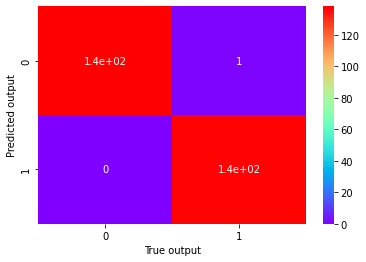

In [39]:
#plot heatmap
y = np.argmax(testY, axis=1)
sns.heatmap(confusion_matrix(predM, y), annot=True, cmap='rainbow')
plt.ylabel('Predicted output')
plt.xlabel('True output')
plt.savefig("heatmap.png")



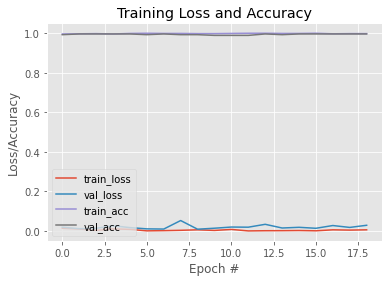

In [42]:
#plot the model
N = 19
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [47]:

# IMPLEMENTING LIVE DETECTION OF FACE MASK

mymodel=load_model('mask_detector.model')

cap=cv2.VideoCapture(0)
face_cascade=cv2.CascadeClassifier('/haarcascade_frontalface_default.xml')

while cap.isOpened():
    _,img=cap.read()
    face=face_cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=4)
    for(x,y,w,h) in face:
        face_img = img[y:y+h, x:x+w]
        cv2.imwrite('temp.jpg',face_img)
        test_image=image.load_img('temp.jpg',target_size=(150,150,3))
        test_image=image.img_to_array(test_image)
        test_image=np.expand_dims(test_image,axis=0)
        pred=mymodel.predict(test_image)[0][0]
        if pred==1:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
            cv2.putText(img,'NO MASK',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),3)
        else:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
            cv2.putText(img,'MASK',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),3)
        datet=str(datetime.datetime.now())
        cv2.putText(img,datet,(400,450),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
          
    cv2.imshow(img)
    
    if cv2.waitKey(1)==ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
